In [1]:
# import the dataset from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# import other required libs
import pandas as pd
import numpy as np

# string manipulation libs
import re
import string
import nltk
from nltk.corpus import stopwords

# viz libs
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
local_save = "E:/coding/github/data_science_with_letras/data"
data = pd.read_csv(f'{local_save}/silver_data_lyrics.csv')

In [42]:
data.head()

,index,song,artist,views,n_verses,n_rows,lyric,clean_lyric,genre,directory
0,0,Stone Cold Break,10-FEET,645,5,19.0,"[""So always let it be more light. now you're i...",so always let it be more light now youre in th...,alternativo,E:/coding/github/webscraping_letras/data/raw/l...
1,0,Little More Than Before (slip Out),10-FEET,763,5,14.0,"[""I don't know since when I changed to such a ...",i dont know since when i changed to such a col...,alternativo,E:/coding/github/webscraping_letras/data/raw/l...
2,0,Islands In The Stream,10-FEET,245,4,52.0,"['Baby when i met you there', 'Was peace unkno...",baby when i met you there was peace unknown i ...,alternativo,E:/coding/github/webscraping_letras/data/raw/l...
3,0,River,10-FEET,345,7,41.0,"[""It's just a waste of time if you can't do an...",its just a waste of time if you cant do anymor...,alternativo,E:/coding/github/webscraping_letras/data/raw/l...
4,0,Shoes,10-FEET,163,8,22.0,"['I came across that scenery, it brought back ...",i came across that scenery it brought back tho...,alternativo,E:/coding/github/webscraping_letras/data/raw/l...


In [68]:
df = pd.DataFrame(data, columns=["clean_lyric","artist"])

In [69]:
df

,clean_lyric,artist
0,so always let it be more light now youre in th...,10-FEET
1,i dont know since when i changed to such a col...,10-FEET
2,baby when i met you there was peace unknown i ...,10-FEET
3,its just a waste of time if you cant do anymor...,10-FEET
4,i came across that scenery it brought back tho...,10-FEET
...,...,...
995,unh ghost town hey get in ill take you for a r...,Ariel Pink
996,go away ghosts go far away i dont want you in ...,Ariel Pink
997,this song is dedicated to the girl that i love...,Ariel Pink
998,they say that part of growing up is getting a ...,Ariel Pink


In [25]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stopwords.words("english")[:20] # <-- import the english stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DERPO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

In [26]:
def preprocess_text(text: str, remove_stopwords: bool) -> str:
    """This utility function sanitizes a string by:
    - removing links
    - removing special characters
    - removing numbers
    - removing stopwords
    - transforming in lowercase
    - removing excessive whitespaces
    Args:
        text (str): the input text you want to clean
        remove_stopwords (bool): whether or not to remove stopwords
    Returns:
        str: the cleaned text
    """

    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    # remove stopwords
    if remove_stopwords:
        # 1. tokenize
        tokens = nltk.word_tokenize(text)
        # 2. check if stopword
        tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]
        # 3. join back together
        text = " ".join(tokens)
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    return text

In [7]:
#df['clean_lyric'].apply(lambda x: preprocess_text(x, remove_stopwords=True))

In [70]:
# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(df['clean_lyric'])

In [71]:
from sklearn.cluster import KMeans

# initialize kmeans with 3 centroids
kmeans = KMeans(n_clusters=4, random_state=42)
# fit the model
kmeans.fit(X)
# store cluster labels in a variable
clusters = kmeans.labels_

c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [72]:
from sklearn.cluster import KMeans

# initialize kmeans with 3 centroids
kmeans = KMeans(n_clusters=4, random_state=42)
# fit the model
kmeans.fit(X)
# store cluster labels in a variable
clusters = kmeans.labels_

In [73]:

from sklearn.decomposition import PCA

# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X.toarray())
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]
# assign clusters and pca vectors to our dataframe 
df['cluster'] = clusters
df['x0'] = x0
df['x1'] = x1

In [43]:
import langdetect

In [74]:

from langdetect import detect 
  
print(detect("Geeksforgeeks is a computer science portal for geeks")) 
df = df.dropna()

en


In [75]:
def find_language(string):
    try:
        language = detect(string)
    except:
        language = "error"
        print("This row throws and error:", string)
    return(language)

In [76]:
df['language'] = df['clean_lyric'].apply(lambda x: find_language(x))

This row throws and error: ]


In [77]:
df.head(20)

,clean_lyric,artist,cluster,x0,x1,language
0,so always let it be more light now youre in th...,10-FEET,2,-0.166237,-0.021721,en
1,i dont know since when i changed to such a col...,10-FEET,2,-0.190861,-0.025456,en
2,baby when i met you there was peace unknown i ...,10-FEET,2,-0.228143,-0.034322,en
3,its just a waste of time if you cant do anymor...,10-FEET,0,0.060391,0.139093,sw
4,i came across that scenery it brought back tho...,10-FEET,0,0.033125,0.096434,en
5,its just a false just a hole just a false just...,10-FEET,2,-0.108287,0.000074,en
6,cry for love cry for yourself cry for love cry...,10-FEET,0,0.091879,0.151726,en
7,jump around jumping free its all depends on yo...,10-FEET,2,-0.161693,-0.007737,en
8,aa kanawanakatta yume aa mezamete ma mo naku o...,10-FEET,0,0.105450,0.221329,sw
9,gradually i came to realize i was growing up a...,10-FEET,2,-0.154293,0.015952,en


In [78]:
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(10)


Cluster 0
me,your,you,of,on,in,my,and,to,the

Cluster 1
no,yo,de,un,con,la,mi,que,el,en

Cluster 2
your,me,my,that,in,it,to,and,the,you

Cluster 3
em,mais,um,se,você,pra,de,eu,não,que


In [79]:
# map clusters to appropriate labels 
cluster_map = {0: "Cluster_1", 1: "Cluster_2", 2: "Cluster_3",3: "Cluster_4"}
# apply mapping
df['cluster'] = df['cluster'].map(cluster_map)

In [80]:
df.head()

,clean_lyric,artist,cluster,x0,x1,language
0,so always let it be more light now youre in th...,10-FEET,Cluster_3,-0.166237,-0.021721,en
1,i dont know since when i changed to such a col...,10-FEET,Cluster_3,-0.190861,-0.025456,en
2,baby when i met you there was peace unknown i ...,10-FEET,Cluster_3,-0.228143,-0.034322,en
3,its just a waste of time if you cant do anymor...,10-FEET,Cluster_1,0.060391,0.139093,sw
4,i came across that scenery it brought back tho...,10-FEET,Cluster_1,0.033125,0.096434,en


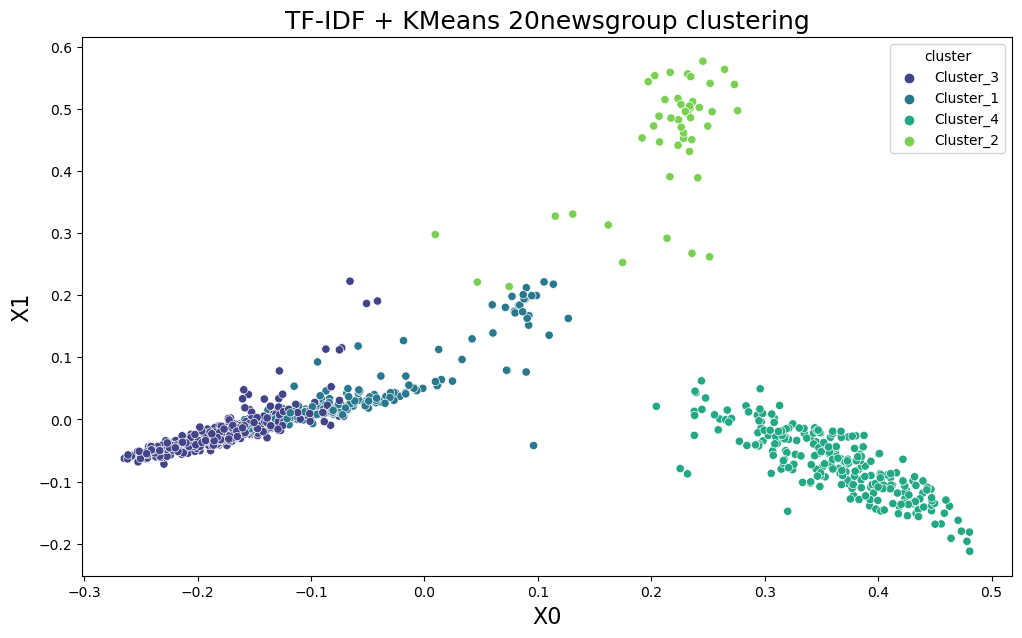

In [81]:
# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans 20newsgroup clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df, x='x0', y='x1', hue='cluster', palette="viridis")
plt.show()

In [84]:
import plotly.express as px

fig = px.scatter(df, y="x1", x="x0", color="cluster", symbol="language")
fig.update_traces(marker_size=5)
fig.show()

In [67]:
df

,nation,medal,count
0,South Korea,gold,24
1,China,gold,10
2,Canada,gold,9
3,South Korea,silver,13
4,China,silver,15
5,Canada,silver,12
6,South Korea,bronze,11
7,China,bronze,8
8,Canada,bronze,12


In [41]:
df.to_csv(f'{local_save}/after_clustering.csv',index=False)